In [1]:
import pandas as pd
import numpy as np

In [2]:
bca = pd.read_csv("bca_preprocessed_data.csv", delimiter=',')
bca.head(5)

,content,score,sentiment
0,mohon donk kembalikan tanda biru hitam saat li...,1,0
1,kenapa sekarang untuk transfer ke blu bca ada ...,2,0
2,oke terimakasih,5,2
3,tolong pihak developer untuk update hp saya ga...,5,2
4,ok,5,2


In [3]:
bca.isnull().sum()

content      61
score         0
sentiment     0
dtype: int64

In [4]:
bca = bca.dropna()

In [5]:
bca.isnull().sum()

content      0
score        0
sentiment    0
dtype: int64

In [6]:
bca.shape

(13939, 3)

#### Creating Topic

In [7]:
import gensim
import gensim.corpora as corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk

#ensure NLTK downloaded
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Darren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Darren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
bca = bca.dropna(subset=["content"])

#### Preprocess

In [9]:
stop_words = set(stopwords.words("indonesian"))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '',text)
    text = re.sub(r'[^\w\s]','',text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

bca["processedwords"] = bca["content"].apply(preprocess_text)

dictionary = corpora.Dictionary(bca["processedwords"])
corpus = [dictionary.doc2bow(text)for text in bca["processedwords"]]

len(dictionary), corpus[:5]


(12820,
 [[(0, 2), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
  [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)],
  [(16, 1), (17, 1)],
  [(13, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)],
  [(23, 1)]])

#### Applying LDA

In [10]:
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=5,
                                   random_state=42,
                                   passes=10)

topics = lda_model.print_topics(num_words=10)
topics

[(0,
  '0.022*"saldo" + 0.020*"ga" + 0.015*"masuk" + 0.013*"flazz" + 0.011*"merah" + 0.011*"bca" + 0.011*"nya" + 0.011*"transaksi" + 0.011*"top" + 0.010*"mulu"'),
 (1,
  '0.053*"good" + 0.038*"bagus" + 0.027*"membantu" + 0.027*"ok" + 0.024*"mudah" + 0.018*"ui" + 0.015*"easy" + 0.012*"transaksi" + 0.010*"cepat" + 0.010*"simple"'),
 (2,
  '0.053*"update" + 0.038*"aplikasi" + 0.030*"force" + 0.030*"close" + 0.028*"bca" + 0.020*"buka" + 0.016*"dibuka" + 0.016*"ga" + 0.014*"mobile" + 0.014*"nya"'),
 (3,
  '0.031*"verifikasi" + 0.030*"bca" + 0.020*"gagal" + 0.017*"bank" + 0.012*"yg" + 0.012*"ribet" + 0.011*"wajah" + 0.011*"ga" + 0.010*"nya" + 0.010*"aplikasi"'),
 (4,
  '0.039*"the" + 0.028*"to" + 0.025*"app" + 0.023*"i" + 0.019*"and" + 0.018*"it" + 0.013*"is" + 0.013*"this" + 0.012*"my" + 0.010*"apps"')]

#### Visualize Topic Distribution

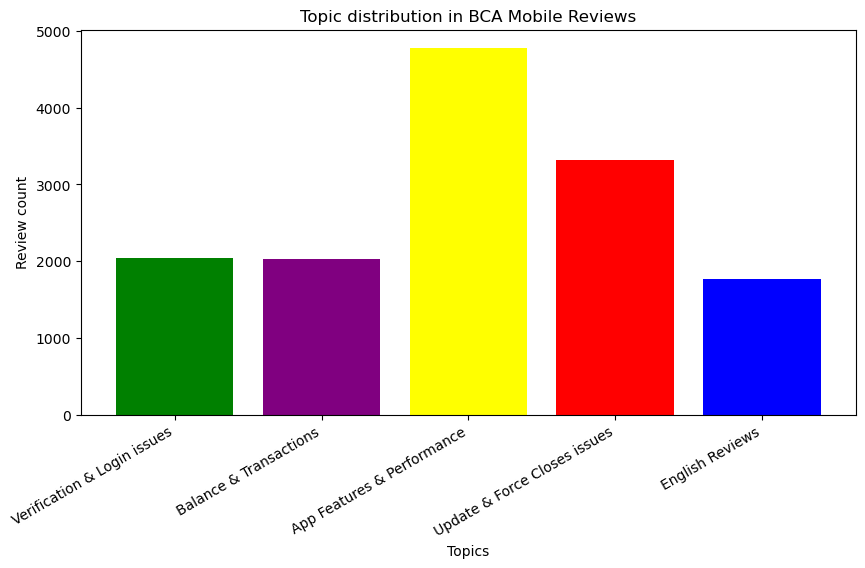

In [11]:
import matplotlib.pyplot as plt

topic_counts = lda_model.get_document_topics(corpus, minimum_probability=0)
topic_distributions = [0] * 5

for doc in topic_counts:
    main_topic = max(doc, key=lambda x: x[1])[0] #get most relevant topic
    topic_distributions[main_topic] += 1

topic_labels =[
    "Verification & Login issues",
    "Balance & Transactions",
    "App Features & Performance",
    "Update & Force Closes issues",
    "English Reviews"
]

#plot bar chart
plt.figure(figsize=(10,5))
plt.bar(topic_labels, topic_distributions, color=["green","purple","yellow","red","blue"])
plt.title("Topic distribution in BCA Mobile Reviews")
plt.xlabel("Topics")
plt.ylabel("Review count")
plt.xticks(rotation=30, ha="right")
plt.show()

#### Visualize Sentiment Distribution per topic 2

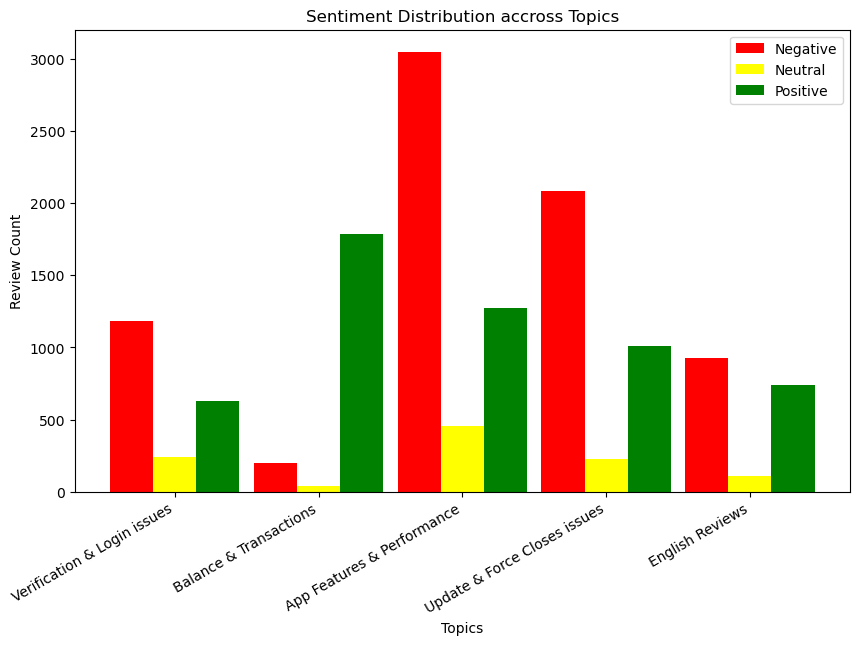

In [12]:
sentiment_per_topic = np.zeros((5,3))

for i, doc in enumerate(topic_counts):
    if i < len(bca):
        main_topic = max(doc, key=lambda x: x[1])[0]
        sentiment = int(bca.iloc[i]["sentiment"])
        sentiment_per_topic[main_topic][sentiment] +=1

#plot sentiment breakdown per topic

sentiment_labels = ["Negative","Neutral","Positive"]
colors = ["red","yellow","green"]


fig, ax = plt.subplots(figsize=(10,6))
bar_width = 0.3

for i in range(3):
    ax.bar(
        np.arange(5) + i * bar_width,  # Added a comma here
        sentiment_per_topic[:, i],
        bar_width,
        label=sentiment_labels[i],
        color=colors[i]
    )

ax.set_xlabel("Topics")
ax.set_ylabel("Review Count")
ax.set_title("Sentiment Distribution accross Topics")
ax.set_xticks(np.arange(5)+ bar_width)
ax.set_xticklabels(topic_labels, rotation=30,ha="right")
ax.legend()

plt.show()

#### Visualize through WordCloud Positive, Neutral and Negative

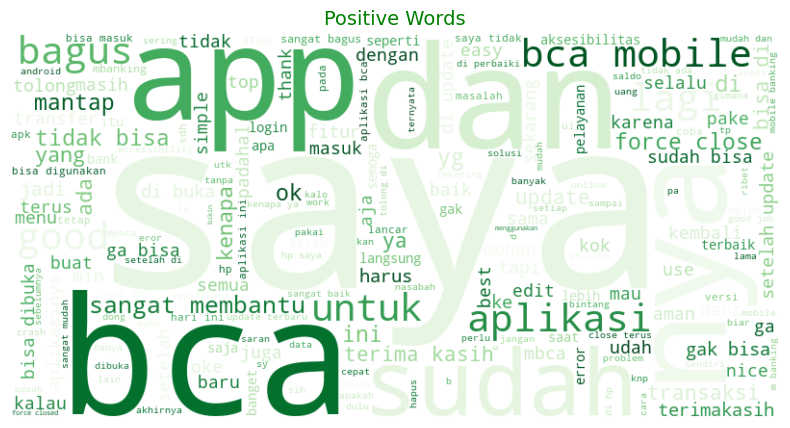

In [23]:
from wordcloud import WordCloud

Positive_text = " ".join(bca[bca["sentiment"]== 2]["content"].dropna())

wordcloud_positives = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(Positive_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_positives, interpolation="bilinear")
plt.title("Positive Words", fontsize=14, color="green")
plt.axis("off")
plt.show()

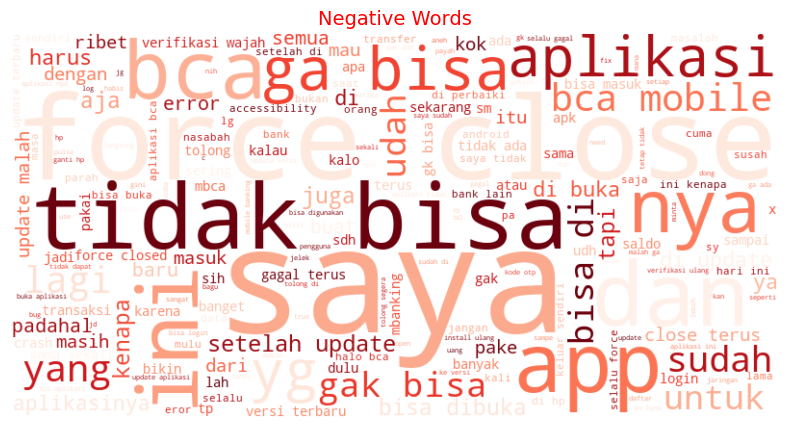

In [25]:
from wordcloud import WordCloud

Negative_text = " ".join(bca[bca["sentiment"]== 0]["content"].dropna())

wordcloud_negatives = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(Negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_negatives, interpolation="bilinear")
plt.title("Negative Words", fontsize=14, color="red")
plt.axis("off")
plt.show()

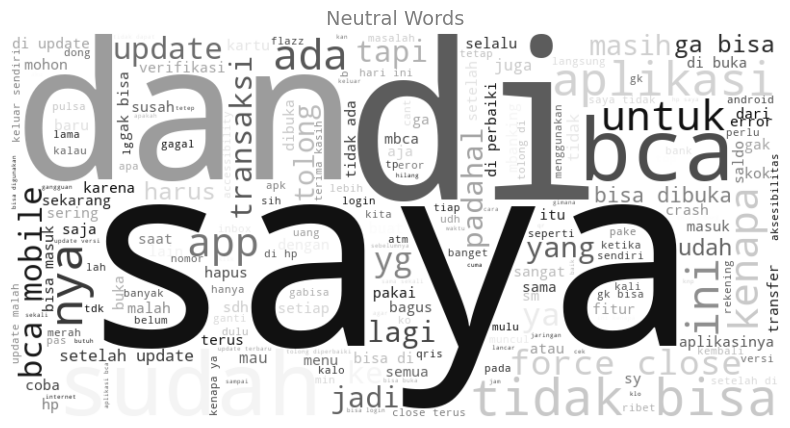

In [28]:
from wordcloud import WordCloud

Neutral_text = " ".join(bca[bca["sentiment"]== 1]["content"].dropna())

wordcloud_neutrals = WordCloud(width=800, height=400, background_color="white", colormap="gray").generate(Neutral_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neutrals, interpolation="bilinear")
plt.title("Neutral Words", fontsize=14, color="gray")
plt.axis("off")
plt.show()